# Assignment1: Logistic Regression, SGD, and Regularization

In this lab session we will implement a Logistic Regression model for __sentence classification__ using Tensorflow. Given a sentence our model will predict if it is a positive or negative piece of text. The dataset we are going to use ranges the polarity annotation from 0 to 5, where 0 denotes extremely negative sentiment,  and 5  is the most  positive. 

Nevertheless, for this lab we'll  simplify the task, and we will translate the 5-way classification task into 2-way classification task (0 $\rightarrow$ _negative,_ ;1 $\rightarrow$ positive),


All in all, the main __objectives__ of this first assignment are the following: 
- Learn how to build, train and evaluate a Logistic Regression Model in Tensorflow.
- Implement L2 reguralization (see Assignment section on the bottom)
- Preprocessing of the input (e.g. one-hot-encoding)
- Explore hyperparameters like:
  - Learning Rates
  - Regularization weight
- Plot learning curves for model selection

## Load data
We'll use the same data used in previous lab 1. You need to follow the same steps specified in lab1.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LAP/Subjects/DL/labs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LAP/Subjects/DL/labs


In [2]:
# Load the data

import re
import random

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data

sst_home = '../data/trees/'  
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

# Note: Unlike with feature based classifiers, evaluation here should be fast, 
# and we don't need to trim down the dev and test sets. 

And extract bag-of-words feature vectors.

In [3]:
import collections
import numpy as np

def feature_function(datasets):
    '''Annotates datasets with feature vectors.'''
    
    # Extract vocabulary
    def tokenize(string):
        return string.split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))
    
    vocabulary = set([word for word in word_counter])
                                
    feature_names = set()
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['features'] = collections.defaultdict(float)
            
            # Extract features (by name) for one example
            word_counter = collections.Counter(tokenize(example['text']))
            for x in word_counter.items():
                if x[0] in vocabulary:
                    example["features"]["word_count_for_" + x[0]] = x[1]
            
            feature_names.update(example['features'].keys())
                            
    # By now, we know what all the features will be, so we can
    # assign indices to them.
    feature_indices = dict(zip(feature_names, range(len(feature_names))))
    indices_to_features = {v: k for k, v in feature_indices.items()}
    dim = len(feature_indices)
                
    # Now we create actual vectors from those indices.
    for dataset in datasets:
        for example in dataset:
            example['vector'] = np.zeros((dim))
            for feature in example['features']:
                example['vector'][feature_indices[feature]] = example['features'][feature]
    return indices_to_features, dim
    
indices_to_features, dim = feature_function([training_set, dev_set, test_set])

And define an evalution function. This is a bit different, since it's designed to let us test an entire big batch of examples at once with the classifier, rather than passing them in one by one. (For larger models or larger training sets, this could run out of memory, but it should be fine for now.)

In [4]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Define Logistic Regression model

Now for the fun part! The below should be a working implementation of logistic regression in TensorFlow.

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.7.0'

In [6]:
class logistic_regression_classifier:
    def __init__(self, dim):
        # Define the hyperparameters
        self.learning_rate = 1.0  # Maybe? Let's tune this
        self.reg_weight = 0.0  # Regularization weight (lambda)
        self.training_epochs = 50  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = dim  # The number of features
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        
        self.trainable_variables = []
        # Define (most of) the model
        self.W = tf.Variable(tf.zeros([self.dim, 2]))
        self.b = tf.Variable(tf.zeros([2]))
        self.trainable_variables.append(self.W)
        self.trainable_variables.append(self.b)
    def model(self,x):
        logits = tf.matmul(x, self.W) + self.b
        return logits
        
    def train(self, training_data, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.float32(np.vstack([dataset[i]['vector'] for i in indices]))
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels

        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)
                  # Define the cost function (here, the exp and sum are built in)
                  cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels))
              
                # This performs the SGD update equation
                gradients = tape.gradient(cost, self.trainable_variables)
                optimizer = tf.optimizers.SGD(self.learning_rate)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                
                # Compute average loss
                avg_cost += cost / (total_batch * self.batch_size)
                
            # Display some statistics about the step
            if (epoch+1) % self.display_epoch_freq == 0:
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost,
                      "Dev acc:", evaluate_classifier(self.classify, dev_set[0:500]), 
                      "Train acc:", evaluate_classifier(self.classify, training_set[0:500]))
    
    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.float32(np.vstack([example['vector'] for example in examples]))
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)

Now let's train it.

In [7]:
classifier = logistic_regression_classifier(dim)
classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00327199674 Dev acc: 0.56 Train acc: 0.548
Epoch: 2 Cost: 0.00309670088 Dev acc: 0.52 Train acc: 0.53
Epoch: 3 Cost: 0.00259405375 Dev acc: 0.754 Train acc: 0.758
Epoch: 4 Cost: 0.0022835962 Dev acc: 0.642 Train acc: 0.69
Epoch: 5 Cost: 0.00214819377 Dev acc: 0.648 Train acc: 0.644
Epoch: 6 Cost: 0.00215072045 Dev acc: 0.694 Train acc: 0.738
Epoch: 7 Cost: 0.00189147843 Dev acc: 0.712 Train acc: 0.77
Epoch: 8 Cost: 0.00199381122 Dev acc: 0.7 Train acc: 0.748
Epoch: 9 Cost: 0.00188918097 Dev acc: 0.746 Train acc: 0.786
Epoch: 10 Cost: 0.00169761141 Dev acc: 0.78 Train acc: 0.848
Epoch: 11 Cost: 0.00166773016 Dev acc: 0.776 Train acc: 0.88
Epoch: 12 Cost: 0.00162450923 Dev acc: 0.768 Train acc: 0.826
Epoch: 13 Cost: 0.00159688713 Dev acc: 0.782 Train acc: 0.862
Epoch: 14 Cost: 0.0015290759 Dev acc: 0.794 Train acc: 0.896
Epoch: 15 Cost: 0.00150995562 Dev acc: 0.764 Train acc: 0.828
Epoch: 16 Cost: 0.00146829558 Dev acc: 0.786 Train acc: 0.896
Epoch: 17 Cost: 0.0014515082

And evaluate it.

In [8]:
evaluate_classifier(classifier.classify, test_set)

0.7946183415705657

## Assignments

### Our goals
  1. **Pick an effective learning rate**:
      - You could set up the learning rate value by passing it as argument (e.g. in `__init__ (self, dim, lr=1.0, ...)` )
      - Try small and larger values to see the behavior of the model.
  
  2. **Implement L2 regularization:**
      - Hint: Add regularization term to overal cost (`self.cost`)
      - Tensorflow already built in method for this. Check the API to find out. 
      - (Optionaly) Code it without using the built in tool for it

  3. **Pick an effective L2 weight:**
      - You could set up the learning rate value by passing it as argument (e.g. in `__init__ (self, dim, lw=1.0, ...)` )
      - Try small and larger values to see the behavior of the model.
  
  4. **Look at some learning curves:**
      - This code might be helpful: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


In [9]:
class logistic_regression_classifier:
    def __init__(self, dim, lr=1.0, lw=1.0):
        # Define the hyperparameters
        self.learning_rate = lr  # Maybe? Let's tune this
        self.reg_weight = lw  # Regularization weight (lambda)
        self.training_epochs = 50  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = dim  # The number of features
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        
        self.trainable_variables = []
        # Define (most of) the model
        self.W = tf.Variable(tf.zeros([self.dim, 2]))
        self.b = tf.Variable(tf.zeros([2]))
        self.trainable_variables.append(self.W)
        self.trainable_variables.append(self.b)
    def model(self,x):
        logits = tf.matmul(x, self.W) + self.b
        return logits
        
    def train(self, training_data, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.float32(np.vstack([dataset[i]['vector'] for i in indices]))
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels

        dev_accs = []
        train_accs = []
        costs = []

        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)
                  # Define the cost function (here, the exp and sum are built in)
                  cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels))
                  # Add L2 regularization
                  cost += self.reg_weight * tf.nn.l2_loss(self.W)
              
                # This performs the SGD update equation
                gradients = tape.gradient(cost, self.trainable_variables)
                optimizer = tf.optimizers.SGD(self.learning_rate)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                
                # Compute average loss
                avg_cost += cost / (total_batch * self.batch_size)
                
            # Display some statistics about the step
            if (epoch+1) % self.display_epoch_freq == 0:
                dev_acc = evaluate_classifier(self.classify, dev_set[0:500])
                train_acc = evaluate_classifier(self.classify, training_set[0:500])
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost,
                      "Dev acc:", dev_acc, 
                      "Train acc:", train_acc)
                costs.append(avg_cost)
                dev_accs.append(dev_acc)
                train_accs.append(train_acc)
        
        return costs, dev_accs, train_accs
    
    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.float32(np.vstack([example['vector'] for example in examples]))
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)

In [10]:
import matplotlib.pyplot as plt
def plot_learning_curves(cost, dev_acc, train_acc):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(dev_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(cost, label='Training Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.show()

## Change learning rate

Try 5 different numbers: 1.0, 0.5, 0.1, 0.01, 0.001

### lr=1.0, lw=0.0

Default learning rate and no regularization

In [11]:
classifier = logistic_regression_classifier(dim, lr=1.0, lw=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00321188546 Dev acc: 0.572 Train acc: 0.608
Epoch: 2 Cost: 0.0025897047 Dev acc: 0.5 Train acc: 0.512
Epoch: 3 Cost: 0.00283791847 Dev acc: 0.622 Train acc: 0.646
Epoch: 4 Cost: 0.00256859767 Dev acc: 0.686 Train acc: 0.706
Epoch: 5 Cost: 0.00219883304 Dev acc: 0.756 Train acc: 0.782
Epoch: 6 Cost: 0.00198279065 Dev acc: 0.748 Train acc: 0.794
Epoch: 7 Cost: 0.00201949198 Dev acc: 0.772 Train acc: 0.846
Epoch: 8 Cost: 0.00185525278 Dev acc: 0.778 Train acc: 0.866
Epoch: 9 Cost: 0.00175032008 Dev acc: 0.742 Train acc: 0.804
Epoch: 10 Cost: 0.0017459573 Dev acc: 0.69 Train acc: 0.702
Epoch: 11 Cost: 0.00171607966 Dev acc: 0.77 Train acc: 0.88
Epoch: 12 Cost: 0.00160150521 Dev acc: 0.786 Train acc: 0.876
Epoch: 13 Cost: 0.00157339312 Dev acc: 0.788 Train acc: 0.87
Epoch: 14 Cost: 0.00157051638 Dev acc: 0.792 Train acc: 0.882
Epoch: 15 Cost: 0.00152171124 Dev acc: 0.738 Train acc: 0.838
Epoch: 16 Cost: 0.00147374824 Dev acc: 0.786 Train acc: 0.854
Epoch: 17 Cost: 0.0014357

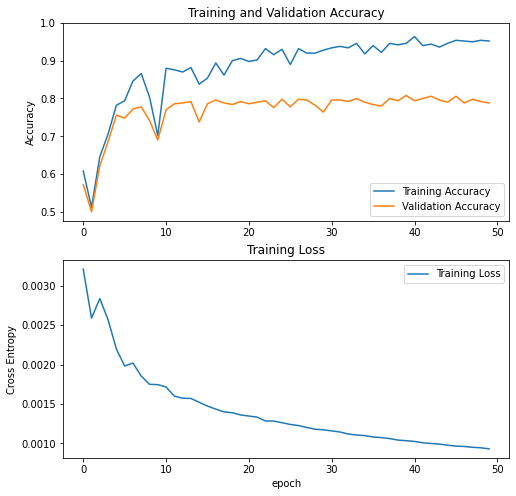

In [12]:
plot_learning_curves(cost, dev_acc, train_acc)

In [13]:
evaluate_classifier(classifier.classify, test_set)

0.7935200439319056

### lr=0.5, lw=0.0

In [14]:
classifier = logistic_regression_classifier(dim, lr=0.5, lw=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00260538585 Dev acc: 0.67 Train acc: 0.624
Epoch: 2 Cost: 0.00244883494 Dev acc: 0.672 Train acc: 0.664
Epoch: 3 Cost: 0.00233096047 Dev acc: 0.712 Train acc: 0.698
Epoch: 4 Cost: 0.00225666119 Dev acc: 0.744 Train acc: 0.722
Epoch: 5 Cost: 0.00218157703 Dev acc: 0.726 Train acc: 0.74
Epoch: 6 Cost: 0.00212185527 Dev acc: 0.752 Train acc: 0.782
Epoch: 7 Cost: 0.00206994312 Dev acc: 0.756 Train acc: 0.79
Epoch: 8 Cost: 0.00203126739 Dev acc: 0.754 Train acc: 0.804
Epoch: 9 Cost: 0.00197677803 Dev acc: 0.754 Train acc: 0.804
Epoch: 10 Cost: 0.00193832139 Dev acc: 0.762 Train acc: 0.826
Epoch: 11 Cost: 0.00190063 Dev acc: 0.766 Train acc: 0.822
Epoch: 12 Cost: 0.00186500198 Dev acc: 0.762 Train acc: 0.81
Epoch: 13 Cost: 0.00183591957 Dev acc: 0.776 Train acc: 0.83
Epoch: 14 Cost: 0.00181384012 Dev acc: 0.766 Train acc: 0.84
Epoch: 15 Cost: 0.00177540467 Dev acc: 0.77 Train acc: 0.844
Epoch: 16 Cost: 0.00174745417 Dev acc: 0.77 Train acc: 0.836
Epoch: 17 Cost: 0.0017246794

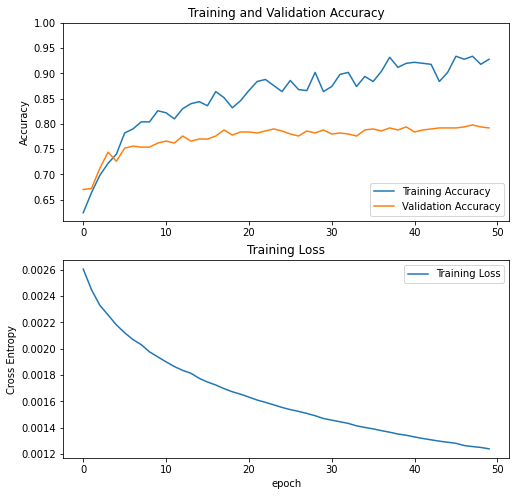

In [15]:
plot_learning_curves(cost, dev_acc, train_acc)

In [16]:
evaluate_classifier(classifier.classify, test_set)

0.7825370675453048

### lr=0.1, lw=0.0

In [17]:
classifier = logistic_regression_classifier(dim, lr=0.1, lw=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00266392506 Dev acc: 0.648 Train acc: 0.596
Epoch: 2 Cost: 0.00260042818 Dev acc: 0.67 Train acc: 0.648
Epoch: 3 Cost: 0.00255606836 Dev acc: 0.672 Train acc: 0.638
Epoch: 4 Cost: 0.00251837 Dev acc: 0.682 Train acc: 0.664
Epoch: 5 Cost: 0.00248611276 Dev acc: 0.686 Train acc: 0.7
Epoch: 6 Cost: 0.00245735887 Dev acc: 0.696 Train acc: 0.664
Epoch: 7 Cost: 0.0024309943 Dev acc: 0.714 Train acc: 0.708
Epoch: 8 Cost: 0.00240702974 Dev acc: 0.716 Train acc: 0.696
Epoch: 9 Cost: 0.00238355831 Dev acc: 0.722 Train acc: 0.702
Epoch: 10 Cost: 0.00236262078 Dev acc: 0.73 Train acc: 0.734
Epoch: 11 Cost: 0.00234205602 Dev acc: 0.732 Train acc: 0.702
Epoch: 12 Cost: 0.00232214713 Dev acc: 0.734 Train acc: 0.698
Epoch: 13 Cost: 0.00230486365 Dev acc: 0.732 Train acc: 0.706
Epoch: 14 Cost: 0.00228646141 Dev acc: 0.742 Train acc: 0.706
Epoch: 15 Cost: 0.00226932904 Dev acc: 0.74 Train acc: 0.754
Epoch: 16 Cost: 0.00225391402 Dev acc: 0.738 Train acc: 0.782
Epoch: 17 Cost: 0.00223827

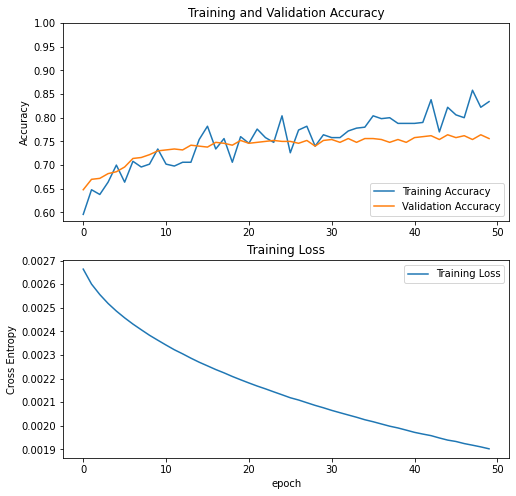

In [18]:
plot_learning_curves(cost, dev_acc, train_acc)

In [19]:
evaluate_classifier(classifier.classify, test_set)

0.7375068643602416

### lr=0.01, lw=0.0

In [20]:
classifier = logistic_regression_classifier(dim, lr=0.01, lw=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00269894325 Dev acc: 0.536 Train acc: 0.518
Epoch: 2 Cost: 0.00268498226 Dev acc: 0.542 Train acc: 0.536
Epoch: 3 Cost: 0.00267478102 Dev acc: 0.566 Train acc: 0.594
Epoch: 4 Cost: 0.00266585592 Dev acc: 0.582 Train acc: 0.588
Epoch: 5 Cost: 0.00265741604 Dev acc: 0.616 Train acc: 0.576
Epoch: 6 Cost: 0.00264996965 Dev acc: 0.642 Train acc: 0.616
Epoch: 7 Cost: 0.0026425398 Dev acc: 0.65 Train acc: 0.604
Epoch: 8 Cost: 0.00263578049 Dev acc: 0.656 Train acc: 0.612
Epoch: 9 Cost: 0.00262916787 Dev acc: 0.654 Train acc: 0.598
Epoch: 10 Cost: 0.00262321392 Dev acc: 0.656 Train acc: 0.622
Epoch: 11 Cost: 0.0026172935 Dev acc: 0.65 Train acc: 0.602
Epoch: 12 Cost: 0.0026109356 Dev acc: 0.652 Train acc: 0.626
Epoch: 13 Cost: 0.00260597537 Dev acc: 0.65 Train acc: 0.664
Epoch: 14 Cost: 0.00260051014 Dev acc: 0.654 Train acc: 0.632
Epoch: 15 Cost: 0.00259445887 Dev acc: 0.652 Train acc: 0.594
Epoch: 16 Cost: 0.00258987653 Dev acc: 0.654 Train acc: 0.642
Epoch: 17 Cost: 0.00258

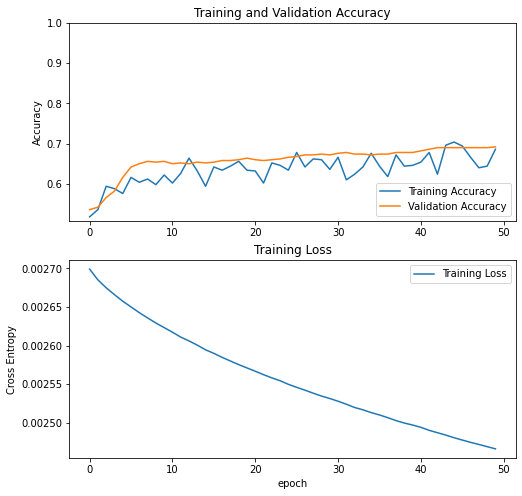

In [21]:
plot_learning_curves(cost, dev_acc, train_acc)

In [22]:
evaluate_classifier(classifier.classify, test_set)

0.6628226249313564

### lr=0.001, lw=0.0

In [23]:
classifier = logistic_regression_classifier(dim, lr=0.001, lw=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00270652771 Dev acc: 0.528 Train acc: 0.538
Epoch: 2 Cost: 0.0027042015 Dev acc: 0.528 Train acc: 0.506
Epoch: 3 Cost: 0.00270213583 Dev acc: 0.528 Train acc: 0.524
Epoch: 4 Cost: 0.00270014745 Dev acc: 0.528 Train acc: 0.556
Epoch: 5 Cost: 0.00269837398 Dev acc: 0.528 Train acc: 0.506
Epoch: 6 Cost: 0.00269655813 Dev acc: 0.528 Train acc: 0.5
Epoch: 7 Cost: 0.0026951211 Dev acc: 0.528 Train acc: 0.52
Epoch: 8 Cost: 0.00269355 Dev acc: 0.53 Train acc: 0.516
Epoch: 9 Cost: 0.00269216555 Dev acc: 0.536 Train acc: 0.542
Epoch: 10 Cost: 0.00269077159 Dev acc: 0.534 Train acc: 0.498
Epoch: 11 Cost: 0.00268931454 Dev acc: 0.534 Train acc: 0.504
Epoch: 12 Cost: 0.00268811453 Dev acc: 0.536 Train acc: 0.534
Epoch: 13 Cost: 0.00268691313 Dev acc: 0.536 Train acc: 0.552
Epoch: 14 Cost: 0.00268574804 Dev acc: 0.542 Train acc: 0.558
Epoch: 15 Cost: 0.00268449984 Dev acc: 0.542 Train acc: 0.546
Epoch: 16 Cost: 0.00268347934 Dev acc: 0.542 Train acc: 0.528
Epoch: 17 Cost: 0.00268244

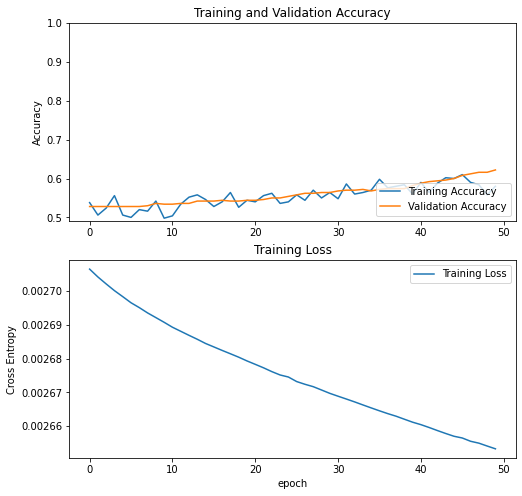

In [24]:
plot_learning_curves(cost, dev_acc, train_acc)

In [25]:
evaluate_classifier(classifier.classify, test_set)

0.5628775398132894

## Change L2 weight

Try 5 different numbers: 1.0, 0.5, 0.1, 0.01, 0.001

### lr=0.1, lw=1.0

In [26]:
classifier = logistic_regression_classifier(dim, lr=0.1, lw=1.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.0026923141 Dev acc: 0.552 Train acc: 0.536
Epoch: 2 Cost: 0.00269071246 Dev acc: 0.57 Train acc: 0.582
Epoch: 3 Cost: 0.00269018603 Dev acc: 0.562 Train acc: 0.596
Epoch: 4 Cost: 0.00268929219 Dev acc: 0.62 Train acc: 0.588
Epoch: 5 Cost: 0.00269004656 Dev acc: 0.58 Train acc: 0.582
Epoch: 6 Cost: 0.00268968637 Dev acc: 0.586 Train acc: 0.556
Epoch: 7 Cost: 0.00268992572 Dev acc: 0.562 Train acc: 0.548
Epoch: 8 Cost: 0.00268975552 Dev acc: 0.658 Train acc: 0.608
Epoch: 9 Cost: 0.00269086985 Dev acc: 0.574 Train acc: 0.584
Epoch: 10 Cost: 0.00268959231 Dev acc: 0.56 Train acc: 0.544
Epoch: 11 Cost: 0.00269015133 Dev acc: 0.564 Train acc: 0.536
Epoch: 12 Cost: 0.00268959347 Dev acc: 0.592 Train acc: 0.54
Epoch: 13 Cost: 0.00269048428 Dev acc: 0.642 Train acc: 0.574
Epoch: 14 Cost: 0.00269012665 Dev acc: 0.648 Train acc: 0.602
Epoch: 15 Cost: 0.00268960628 Dev acc: 0.588 Train acc: 0.556
Epoch: 16 Cost: 0.0026902766 Dev acc: 0.65 Train acc: 0.6
Epoch: 17 Cost: 0.002689853

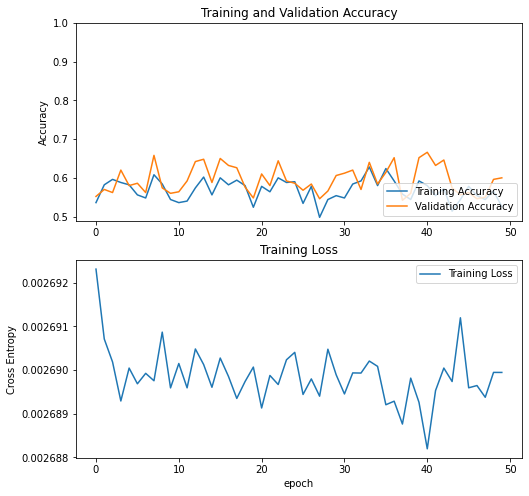

In [27]:
plot_learning_curves(cost, dev_acc, train_acc)

In [28]:
evaluate_classifier(classifier.classify, test_set)

0.5475013728720484

### lr=0.1, lw=0.5

In [29]:
classifier = logistic_regression_classifier(dim, lr=0.1, lw=0.5)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00268466095 Dev acc: 0.616 Train acc: 0.564
Epoch: 2 Cost: 0.00267490558 Dev acc: 0.654 Train acc: 0.6
Epoch: 3 Cost: 0.00267475122 Dev acc: 0.648 Train acc: 0.632
Epoch: 4 Cost: 0.00267431303 Dev acc: 0.64 Train acc: 0.624
Epoch: 5 Cost: 0.00267428649 Dev acc: 0.64 Train acc: 0.596
Epoch: 6 Cost: 0.00267352141 Dev acc: 0.648 Train acc: 0.612
Epoch: 7 Cost: 0.00267466367 Dev acc: 0.654 Train acc: 0.6
Epoch: 8 Cost: 0.00267426507 Dev acc: 0.64 Train acc: 0.606
Epoch: 9 Cost: 0.0026738653 Dev acc: 0.67 Train acc: 0.584
Epoch: 10 Cost: 0.0026750816 Dev acc: 0.668 Train acc: 0.618
Epoch: 11 Cost: 0.00267427904 Dev acc: 0.66 Train acc: 0.618
Epoch: 12 Cost: 0.00267519616 Dev acc: 0.63 Train acc: 0.612
Epoch: 13 Cost: 0.00267594098 Dev acc: 0.662 Train acc: 0.59
Epoch: 14 Cost: 0.00267380569 Dev acc: 0.662 Train acc: 0.636
Epoch: 15 Cost: 0.00267513981 Dev acc: 0.65 Train acc: 0.626
Epoch: 16 Cost: 0.00267395563 Dev acc: 0.65 Train acc: 0.63
Epoch: 17 Cost: 0.00267382269 Dev

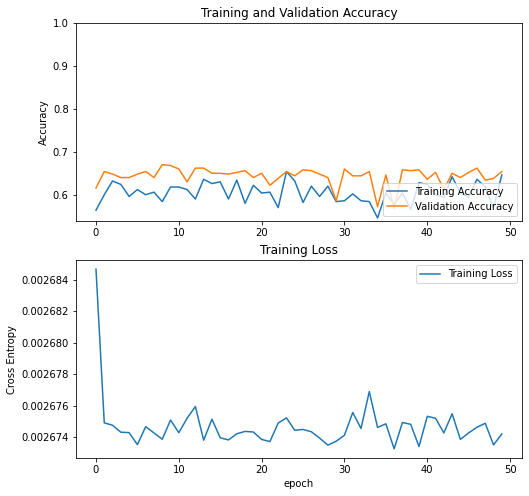

In [30]:
plot_learning_curves(cost, dev_acc, train_acc)

In [31]:
evaluate_classifier(classifier.classify, test_set)

0.5941790225151016

### lr=0.1, lw=0.1

In [32]:
classifier = logistic_regression_classifier(dim, lr=0.1, lw=0.1)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00266992813 Dev acc: 0.658 Train acc: 0.618
Epoch: 2 Cost: 0.00262977532 Dev acc: 0.658 Train acc: 0.658
Epoch: 3 Cost: 0.00261371583 Dev acc: 0.664 Train acc: 0.632
Epoch: 4 Cost: 0.002605282 Dev acc: 0.672 Train acc: 0.624
Epoch: 5 Cost: 0.00260261656 Dev acc: 0.674 Train acc: 0.63
Epoch: 6 Cost: 0.00260062446 Dev acc: 0.672 Train acc: 0.642
Epoch: 7 Cost: 0.00259916 Dev acc: 0.686 Train acc: 0.694
Epoch: 8 Cost: 0.00259909639 Dev acc: 0.684 Train acc: 0.63
Epoch: 9 Cost: 0.00259805378 Dev acc: 0.68 Train acc: 0.68
Epoch: 10 Cost: 0.00259841536 Dev acc: 0.688 Train acc: 0.682
Epoch: 11 Cost: 0.00259849406 Dev acc: 0.684 Train acc: 0.674
Epoch: 12 Cost: 0.00259730965 Dev acc: 0.68 Train acc: 0.646
Epoch: 13 Cost: 0.00259825797 Dev acc: 0.688 Train acc: 0.686
Epoch: 14 Cost: 0.00259631546 Dev acc: 0.686 Train acc: 0.656
Epoch: 15 Cost: 0.00259726588 Dev acc: 0.686 Train acc: 0.68
Epoch: 16 Cost: 0.00259771943 Dev acc: 0.686 Train acc: 0.634
Epoch: 17 Cost: 0.0025982642

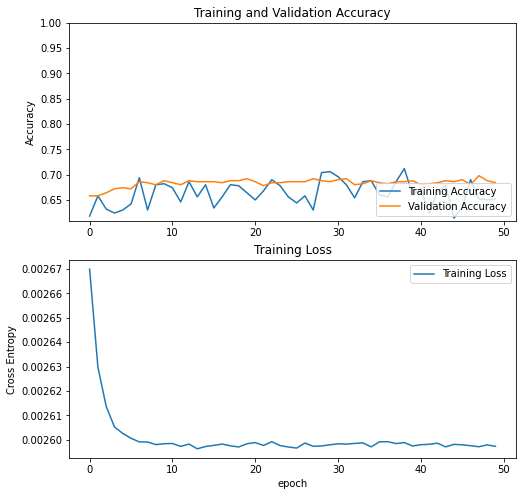

In [33]:
plot_learning_curves(cost, dev_acc, train_acc)

In [34]:
evaluate_classifier(classifier.classify, test_set)

0.6688632619439868

### lr=0.1, lw=0.01

In [35]:
classifier = logistic_regression_classifier(dim, lr=0.1, lw=0.01)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00266437535 Dev acc: 0.668 Train acc: 0.59
Epoch: 2 Cost: 0.00260455045 Dev acc: 0.668 Train acc: 0.676
Epoch: 3 Cost: 0.00256383605 Dev acc: 0.67 Train acc: 0.638
Epoch: 4 Cost: 0.00253208471 Dev acc: 0.674 Train acc: 0.644
Epoch: 5 Cost: 0.00250634947 Dev acc: 0.684 Train acc: 0.662
Epoch: 6 Cost: 0.00248430157 Dev acc: 0.688 Train acc: 0.676
Epoch: 7 Cost: 0.00246450258 Dev acc: 0.702 Train acc: 0.71
Epoch: 8 Cost: 0.0024478971 Dev acc: 0.712 Train acc: 0.67
Epoch: 9 Cost: 0.0024325063 Dev acc: 0.71 Train acc: 0.662
Epoch: 10 Cost: 0.0024194119 Dev acc: 0.724 Train acc: 0.71
Epoch: 11 Cost: 0.00240747863 Dev acc: 0.73 Train acc: 0.712
Epoch: 12 Cost: 0.00239734654 Dev acc: 0.736 Train acc: 0.758
Epoch: 13 Cost: 0.00238788826 Dev acc: 0.736 Train acc: 0.7
Epoch: 14 Cost: 0.00237904419 Dev acc: 0.73 Train acc: 0.71
Epoch: 15 Cost: 0.00237104646 Dev acc: 0.734 Train acc: 0.744
Epoch: 16 Cost: 0.0023644045 Dev acc: 0.74 Train acc: 0.758
Epoch: 17 Cost: 0.00235858839 Dev

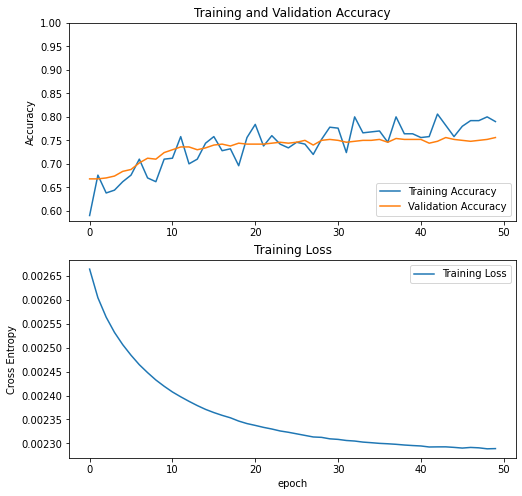

In [36]:
plot_learning_curves(cost, dev_acc, train_acc)

In [37]:
evaluate_classifier(classifier.classify, test_set)

0.7259747391543108

### lr=0.1, lw=0.001

In [38]:
classifier = logistic_regression_classifier(dim, lr=0.1, lw=0.001)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Epoch: 1 Cost: 0.00266441051 Dev acc: 0.66 Train acc: 0.624
Epoch: 2 Cost: 0.00260080514 Dev acc: 0.668 Train acc: 0.62
Epoch: 3 Cost: 0.00255617127 Dev acc: 0.674 Train acc: 0.658
Epoch: 4 Cost: 0.00251995772 Dev acc: 0.684 Train acc: 0.654
Epoch: 5 Cost: 0.0024891058 Dev acc: 0.692 Train acc: 0.696
Epoch: 6 Cost: 0.00246038265 Dev acc: 0.698 Train acc: 0.72
Epoch: 7 Cost: 0.0024343438 Dev acc: 0.71 Train acc: 0.708
Epoch: 8 Cost: 0.00241121231 Dev acc: 0.718 Train acc: 0.686
Epoch: 9 Cost: 0.00238663377 Dev acc: 0.682 Train acc: 0.68
Epoch: 10 Cost: 0.00236895378 Dev acc: 0.73 Train acc: 0.73
Epoch: 11 Cost: 0.00234865863 Dev acc: 0.734 Train acc: 0.722
Epoch: 12 Cost: 0.00233208807 Dev acc: 0.736 Train acc: 0.748
Epoch: 13 Cost: 0.00231426 Dev acc: 0.732 Train acc: 0.764
Epoch: 14 Cost: 0.00229813647 Dev acc: 0.742 Train acc: 0.71
Epoch: 15 Cost: 0.00228058523 Dev acc: 0.728 Train acc: 0.73
Epoch: 16 Cost: 0.00226801704 Dev acc: 0.74 Train acc: 0.718
Epoch: 17 Cost: 0.00225319923 De

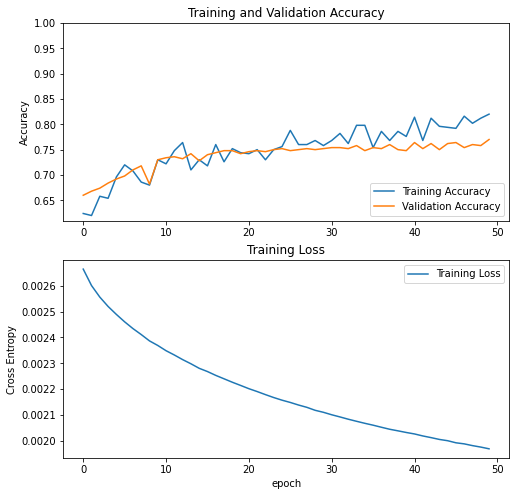

In [39]:
plot_learning_curves(cost, dev_acc, train_acc)

In [40]:
evaluate_classifier(classifier.classify, test_set)

0.7468423942888522

# Atribution:
Adapted by Oier Lopez de Lacalle, Olatz Perez de Viñaspre and Ander Barrena, based on a notebook by Sam Bowman at NYU